Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Kelley"
COLLABORATORS = ""


---

Update: For those of you who have trouble getting your twitter developer account working: 
1. Run the cell to set up your notebook below (the one that starts with import csv).
2. Skip Question 1 and Question 2a.
3. Start with Question 2a-X instead. 
4. After completing 2a-X, continue on to question 2b and proceed as normal.

# Project 1: Trump, Twitter, and Text

Welcome to the first project of Data 100! In this project, we will work with the Twitter API in order to analyze Donald Trump's tweets.

**The project is due 11:59pm Thursday, October 25, California Time.**

You do not have to work on this project before the midterm, but you might find it helpful, since it goes over a lot of pandas materials that we haven't used in a while.

**Fun:**

We intend this project to be fun! You will analyze actual data from the Twitter API. You will also draw conclusions about the current (and often controversial) US President's tweet behavior. If you find yourself getting frustrated or stuck on one problem for too long, we suggest coming into office hours and working with friends in the class.

With that in mind, let's get started!

In [2]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import json

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

# Downloading Recent Tweets

---

Since we'll be looking at Twitter data, we need to download the data from Twitter!

Twitter provides an API for downloading tweet data in large batches.  The `tweepy` package makes it fairly easy to use.

In [3]:
## Make sure you are in your data100 conda environment if you are working locally.
# The following should run:
import tweepy

There are instructions on using `tweepy` [here](http://tweepy.readthedocs.io/en/v3.5.0/getting_started.html), but we will give you example code.

Twitter requires you to have authentication keys to access their API.  To get your keys, you'll have to sign up as a Twitter developer.  The next question will walk you through this process.

## Question 1

Follow the instructions below to get your Twitter API keys.  **Read the instructions completely before starting.**

1. [Create a Twitter account](https://twitter.com).  You can use an existing account if you have one; if you prefer to not do this assignment under your regular account, feel free to create a throw-away account.
2. Under account settings, add your phone number to the account.
3. [Create a Twitter developer account](https://dev.twitter.com/resources/signup) by clicking the 'Apply' button on the top right of the page. Attach it to your Twitter account. You'll have to fill out a form describing what you want to do with the developer account. Explain that you are doing this for a class at UC Berkeley and that you don't know exactly what you're building yet and just need the account to get started. These applications are approved by some sort of AI system, so it doesn't matter exactly what you write. Just don't enter a bunch of alweiofalwiuhflawiuehflawuihflaiwhfe type stuff or you might get rejected.
4. Once you're logged into your developer account, [create an application for this assignment](https://apps.twitter.com/app/new).  You can call it whatever you want, and you can write any URL when it asks for a web site.  You don't need to provide a callback URL.
5. On the page for that application, find your Consumer Key and Consumer Secret.
6. On the same page, create an Access Token.  Record the resulting Access Token and Access Token Secret.
7. Edit the file [keys.json](keys.json) and replace the placeholders with your keys.  


## WARNING (Please Read) !!!!


### Protect your Twitter Keys
<span style="color:red">
If someone has your authentication keys, they can access your Twitter account and post as you!  So don't give them to anyone, and **don't write them down in this notebook**. 
</span>
The usual way to store sensitive information like this is to put it in a separate file and read it programmatically.  That way, you can share the rest of your code without sharing your keys.  That's why we're asking you to put your keys in `keys.json` for this assignment.


### Avoid making too many API calls.

<span style="color:red">
Twitter limits developers to a certain rate of requests for data.  If you make too many requests in a short period of time, you'll have to wait awhile (around 15 minutes) before you can make more.  </span> 
So carefully follow the code examples you see and don't rerun cells without thinking.  Instead, always save the data you've collected to a file.  We've provided templates to help you do that.


### Be careful about which functions you call!

<span style="color:red">
This API can retweet tweets, follow and unfollow people, and modify your twitter settings.  Be careful which functions you invoke! </span> One of the sp18 instructors accidentally re-tweeted some tweets because that instructor typed `retweet` instead of `retweet_count`. 
</span>


In [4]:
import json
key_file = 'keys.json'
# Loading your keys from keys.json (which you should have filled
# in in question 1):
with open(key_file) as f:
    keys = json.load(f)
# if you print or view the contents of keys be sure to delete the cell!

This cell tests the Twitter authentication. It should run without errors or warnings and display your Twitter username.

In [5]:
import tweepy
from tweepy import TweepError
import logging

try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

## Question 2

In the example below, we have loaded some tweets by @BerkeleyData.  Run it and read the code.

In [ ]:
from pathlib import Path
import json

ds_tweets_save_path = "BerkeleyData_recent_tweets.json"
# Guarding against attempts to download the data multiple
# times:
if not Path(ds_tweets_save_path).is_file():
    # Getting as many recent tweets by @BerkeleyData as Twitter will let us have.
    # We use tweet_mode='extended' so that Twitter gives us full 280 character tweets.
    # This was a change introduced in September 2017.
    
    # The tweepy Cursor API actually returns "sophisticated" Status objects but we 
    # will use the basic Python dictionaries stored in the _json field. 
    example_tweets = [t._json for t in tweepy.Cursor(api.user_timeline, id="BerkeleyData", 
                                             tweet_mode='extended').items()]
    
    # Saving the tweets to a json file on disk for future analysis
    with open(ds_tweets_save_path, "w") as f:        
        json.dump(example_tweets, f)

# Re-loading the json file:
with open(ds_tweets_save_path, "r") as f:
    example_tweets = json.load(f)

Assuming everything ran correctly you should be able to look at the first tweet by running the cell below.

<span style="color:red">
**Warning** Do not attempt to view all the tweets in a notebook.  It will likely freeze your browser.  The following would be a **bad idea**:
```python
    pprint(example_tweets)
```

</span> 

In [ ]:
# Looking at one tweet object, which has type Status: 
from pprint import pprint # ...to get a more easily-readable view.
pprint(example_tweets[0])

## Question 2a

### What you need to do. 

Re-factor the above code fragment into reusable snippets below.  You should not need to make major modifications; this is mostly an exercise in understanding the above code block. 

In [ ]:
def load_keys(path):
    """Loads your Twitter authentication keys from a file on disk.
    
    Args:
        path (str): The path to your key file.  The file should
          be in JSON format and look like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }
    
    Returns:
        dict: A dictionary mapping key names (like "consumer_key") to
          key values."""
    import json
    with open(path) as f:
        keys = json.load(f)
    return keys

In [ ]:
def download_recent_tweets_by_user(user_account_name, keys):
    """Downloads tweets by one Twitter user.

    Args:
        user_account_name (str): The name of the Twitter account
          whose tweets will be downloaded.
        keys (dict): A Python dictionary with Twitter authentication
          keys (strings), like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }

    Returns:
        list: A list of Dictonary objects, each representing one tweet."""
    import tweepy
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    return [t._json for t in tweepy.Cursor(api.user_timeline, id=user_account_name, 
                                             tweet_mode='extended').items()]


In [ ]:
def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    This function makes no guarantee about the format of the saved
    tweets, **except** that calling load_tweets(path) after
    save_tweets(tweets, path) will produce the same list of tweets
    and that only the file at the given path is used to store the
    tweets.  (That means you can implement this function however
    you want, as long as saving and loading works!)

    Args:
        tweets (list): A list of tweet objects (of type Dictionary) to
          be saved.
        path (str): The place where the tweets will be saved.

    Returns:
        None"""
    with open(path, "w") as f:        
        json.dump(tweets, f)

In [ ]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Dictionary objects, each representing one tweet."""
    
    with open(path, "r") as f:
        all_tweets = json.load(f)
    return all_tweets

In [ ]:
def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available.
    
    The first time you call this function, it will download tweets by
    a user.  Subsequent calls will not re-download the tweets; instead
    they'll load the tweets from a save file in your local filesystem.
    All this is done using the functions you defined in the previous cell.
    This has benefits and drawbacks that often appear when you cache data:
    
    +: Using this function will prevent extraneous usage of the Twitter API.
    +: You will get your data much faster after the first time it's called.
    -: If you really want to re-download the tweets (say, to get newer ones,
       or because you screwed up something in the previous cell and your
       tweets aren't what you wanted), you'll have to find the save file
       (which will look like <something>_recent_tweets.pkl) and delete it.
    
    Args:
        user_account_name (str): The Twitter handle of a user, without the @.
        keys_path (str): The path to a JSON keys file in your filesystem.
    """
    
    path = "trump_tweets.json"
    if not Path(path).is_file():
        downloaded = download_recent_tweets_by_user(user_account_name, load_keys(keys_path))
        save_tweets(downloaded, path)
    return load_tweets(path)

If everything was implemented correctly you should be able to obtain roughly the last 3000 tweets by the `realdonaldtrump`.  (This may take a few minutes)

In [ ]:
# When you are done, run this cell to load @realdonaldtrump's tweets.
# Note the function get_tweets_with_cache.  You may find it useful
# later.
trump_tweets = get_tweets_with_cache("realdonaldtrump", key_file)
print("Number of tweets downloaded:", len(trump_tweets))

### Question 2a-X

This alternate starting point is here for those of you who have trouble getting a Twitter developer account. You should only use this if Twitter has rejected your application or if they have gone silent on you for at least a day. You'll miss out on some of the learning experience... but it seems like this might be necessary for some. If your twitter account is working fine, skip this problem!

Start by running the following cells, which will download and then load Donald Trump's most recent tweets.

In [6]:
# Download the dataset
from utils import fetch_and_cache
data_url = 'http://www.ds100.org/fa18/assets/datasets/realdonaldtrump_recent_tweets.json'
file_name = 'realdonaldtrump_recent_tweets.json'

dest_path = fetch_and_cache(data_url=data_url, file=file_name)
print(f'Located at {dest_path}')

Using version already downloaded: Tue Oct 23 08:16:29 2018
MD5 hash of file: 216176fb098cd5d6b40b373b98bd3e6d
Located at data/realdonaldtrump_recent_tweets.json


In [7]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Dictionary objects, each representing one tweet."""
    
    with open(path, "rb") as f:
        import json
        return json.load(f)

In [8]:
trump_tweets = load_tweets(dest_path)

If everything is working correctly correctly this should load roughly the last 3000 tweets by `realdonaldtrump`.

In [9]:
assert 2000 <= len(trump_tweets) <= 4000

If the assert statement above works, then continue on to question 2b.

### Question 2b

We are limited to how many tweets we can download.  In what month is the oldest tweet from Trump?

In [10]:
# Enter the number of the month of the oldest tweet (e.g. 1 for January)
oldest_month = 10

##trump_tweets[3213]


## Question 3


**IMPORTANT! PLEASE READ**

Unfortunately, even if you have a working Twitter developer account, you cannot download older tweets using the public APIs.  Fortunately, we have a snapshot of earlier tweets that we can combine with the newer data that you downloaded   

We will again use the `fetch_and_cache` utility to download the dataset. 

In [11]:
# Download the dataset
from utils import fetch_and_cache
data_url = 'http://www.ds100.org/fa18/assets/datasets/old_trump_tweets.json.zip'
file_name = 'old_trump_tweets.json.zip'

dest_path = fetch_and_cache(data_url=data_url, file=file_name)
print(f'Located at {dest_path}')

Using version already downloaded: Tue Oct 23 08:16:29 2018
MD5 hash of file: b6e33874de91d1a40207cdf9f9b51a09
Located at data/old_trump_tweets.json.zip


Finally, we we will load the tweets directly from the compressed file without decompressing it first.

In [12]:
my_zip = zipfile.ZipFile(dest_path, 'r')
with my_zip.open("old_trump_tweets.json", "r") as f:
    old_trump_tweets = json.load(f)

This data is formatted identically to the recent tweets we just downloaded:

In [13]:
from pprint import pprint

In [14]:
pprint(old_trump_tweets[0])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Wed Oct 12 14:00:48 +0000 2016',
 'entities': {'hashtags': [{'indices': [23, 38], 'text': 'CrookedHillary'}],
              'media': [{'display_url': 'pic.twitter.com/wjsl8ITVvk',
                         'expanded_url': 'https://twitter.com/realDonaldTrump/status/786204978629185536/video/1',
                         'id': 786204885318561792,
                         'id_str': '786204885318561792',
                         'indices': [39, 62],
                         'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/786204885318561792/pu/img/XqMoixLm83FzkAbn.jpg',
                         'media_url_https': 'https://pbs.twimg.com/ext_tw_video_thumb/786204885318561792/pu/img/XqMoixLm83FzkAbn.jpg',
                         'sizes': {'large': {'h': 576,
                                             'resize': 'fit',
                                             'w': 1024},
                                   'medium': {'h': 338

As a dictionary we can also list the keys:

In [15]:
old_trump_tweets[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

Since we're giving you a zipfile of old tweets, you may wonder why we didn't just give you a zipfile of ALL tweets and save you the trouble of creating a Twitter developer account. The reason is that we wanted you to see what it's like to collect data from the real world on your own. It can be a pain!

And for those of you that never got your developer accounts, you can see it can be even more of a pain that we expected. Sorry to anybody that wasted a bunch of time trying to get things working.

### Question 3a

Merge the `old_trump_tweets` and the `trump_tweets` we downloaded from twitter into one giant list of tweets. 

**Important:** There may be some overlap so be sure to eliminate duplicate tweets.  
**Hint:** the `id` of a tweet is always unique.

In [16]:
trump_tweets[0]['id']

1052233253040640001

In [17]:
no_dup = {}
for i in trump_tweets:
    no_dup.update({i['id']: i})
for j in old_trump_tweets:
    no_dup.update({j['id']: j})
all_tweets = list(no_dup.values())

In [18]:
assert len(all_tweets) > len(trump_tweets)
assert len(all_tweets) > len(old_trump_tweets)

### Question 3b

Construct a DataFrame called `trump` containing all the tweets stored in `all_tweets`. The index of the dataframe should be the ID of each tweet (looks something like `907698529606541312`). It should have these columns:

- `time`: The time the tweet was created encoded as a datetime object. (Use `pd.to_datetime` to encode the timestamp.)
- `source`: The source device of the tweet.
- `text`: The text of the tweet.
- `retweet_count`: The retweet count of the tweet. 

Finally, **the resulting dataframe should be sorted by the index.**

**Warning:** *Some tweets will store the text in the `text` field and other will use the `full_text` field.*

In [62]:
time = [d['created_at'] for d in all_tweets]
pd.to_datetime(time)
text = [d.get('full_text', d.get('text')) for d in all_tweets]
source = [d['source'] for d in all_tweets]
retweet = [d['retweet_count'] for d in all_tweets]
_id = [d['id'] for d in all_tweets]

In [63]:
trump = pd.DataFrame(
    {'time': pd.to_datetime(time),
     'source': source,
     'text': text,
     'retweet_count': retweet,
     'id': _id
    }).set_index('id')
trump.sort_index()

,time,source,text,retweet_count
id,,,,
690171032150237184,2016-01-21 13:56:11,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059
690171403388104704,2016-01-21 13:57:39,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339
690173226341691392,2016-01-21 14:04:54,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006
690176882055114758,2016-01-21 14:19:26,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266
690180284189310976,2016-01-21 14:32:57,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886
690271688127213568,2016-01-21 20:36:09,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",New Day on CNN treats me very badly. @AlisynCamerota is a disaster. Not going to watch anymore.,1429
690272687168458754,2016-01-21 20:40:07,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","Happy birthday to my friend, the great @jacknicklaus - a totally special guy!",1053
690313350278819840,2016-01-21 23:21:42,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Thank you, Iowa! #Trump2016 https://t.co/ryhEheTLqN",2329
690315202261155840,2016-01-21 23:29:04,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Thank you! #Trump2016 https://t.co/pcdmyIO1Zt,1463


In [21]:
assert isinstance(trump, pd.DataFrame)
assert trump.shape[0] < 11000
assert trump.shape[1] >= 4
assert 831846101179314177 in trump.index
assert 753063644578144260 in trump.index
assert all(col in trump.columns for col in ['time', 'source', 'text', 'retweet_count'])
# If you fail these tests, you probably tried to use __dict__ or _json to read in the tweets
assert np.sometrue([('Twitter for iPhone' in s) for s in trump['source'].unique()])
assert trump['time'].dtype == np.dtype('<M8[ns]')
assert trump['text'].dtype == np.dtype('O')
assert trump['retweet_count'].dtype == np.dtype('int64')

## Question 4: Tweet Source Analysis

In the following questions, we are going to find out the charateristics of Trump tweets and the devices used for the tweets.

First let's examine the source field:

In [22]:
trump['source'].unique()

array([ '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>',
       '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>',
       '<a href="https://periscope.tv" rel="nofollow">Periscope</a>'], dtype=object)

## Question 4a

Remove the HTML tags from the source field. 

**Hint:** Use `trump['source'].str.replace` and your favorite regular expression.

In [23]:
trump['source'] = trump['source'].str.replace(r'<[^>]*>', '')

In [24]:
from datetime import datetime
ELEC_DATE = datetime(2016, 11, 8)
INAUG_DATE = datetime(2017, 1, 20)
assert set(trump[(trump['time'] > ELEC_DATE) & (trump['time'] < INAUG_DATE) ]['source'].unique()) == set(['Twitter Ads',
 'Twitter Web Client',
 'Twitter for Android',
 'Twitter for iPhone'])

We can see in the following plot that there are two device types that are more commonly used

Text(0,0.5,'Number of Tweets')

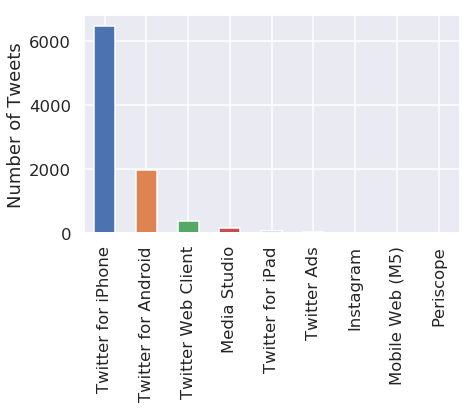

In [25]:
trump['source'].value_counts().plot(kind="bar")
plt.ylabel("Number of Tweets")

## Question 4b


Is there a difference between his Tweet behavior across these devices? We will attempt to answer this question in our subsequent analysis.

First, we'll take a look at whether Trump's tweets from an Android come at different times than his tweets from an iPhone. Note that Twitter gives us his tweets in the [UTC timezone](https://www.wikiwand.com/en/List_of_UTC_time_offsets) (notice the `+0000` in the first few tweets)

In [26]:
for t in trump_tweets[0:3]:
    print(t['created_at'])

Tue Oct 16 16:22:11 +0000 2018
Tue Oct 16 16:18:08 +0000 2018
Tue Oct 16 15:26:33 +0000 2018


We'll convert the tweet times to US Eastern Time, the timezone of New York and Washington D.C., since those are the places we would expect the most tweet activity from Trump.

In [27]:
trump['est_time'] = (
    trump['time'].dt.tz_localize("UTC") # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
trump.head()

,time,source,text,retweet_count,est_time
id,,,,,
1052233253040640001,2018-10-16 16:22:11,Twitter for iPhone,REGISTER TO https://t.co/0pWiwCHGbh! #MAGA🇺🇸 https://t.co/ACTMe53TZU,5415,2018-10-16 11:22:11-05:00
1052232230972678145,2018-10-16 16:18:08,Twitter for iPhone,RT @WhiteHouse: https://t.co/RNqLpOtS3O,4478,2018-10-16 11:18:08-05:00
1052219253384994816,2018-10-16 15:26:33,Twitter for iPhone,"Is it really possible that Bruce Ohr, whose wife Nellie was paid by Simpson and GPS Fusion for work done on the Fake Dossier, and who was used as a Pawn in this whole SCAM (WITCH HUNT), is still working for the Department of Justice????? Can this really be so?????",13103,2018-10-16 10:26:33-05:00
1052217314463100928,2018-10-16 15:18:51,Twitter for iPhone,“Conflict between Glen Simpson’s testimony to another House Panel about his contact with Justice Department official Bruce Ohr. Ohr was used by Simpson and Steele as a Back Channel to get (FAKE) Dossier to FBI. Simpson pleading Fifth.” Catherine Herridge. Where is Jeff Sessions?,6271,2018-10-16 10:18:51-05:00
1052213711295930368,2018-10-16 15:04:32,Twitter for iPhone,"“Federal Judge throws out Stormy Danials lawsuit versus Trump. Trump is entitled to full legal fees.” @FoxNews Great, now I can go after Horseface and her 3rd rate lawyer in the Great State of Texas. She will confirm the letter she signed! She knows nothing about me, a total ...",14594,2018-10-16 10:04:32-05:00


**What you need to do:**

Add a column called `hour` to the `trump` table which contains the hour of the day as floating point number computed by:

$$
\text{hour} + \frac{\text{minute}}{60} + \frac{\text{second}}{60^2}
$$


In [28]:
trump['hour'] = [each.hour + each.minute/60 + each.second/(60 ** 2) for each in trump['est_time']]
# make a bar plot here
#x = np.arange(0, 26, 2)
#trump['hour'].
#sns.barplot(x = 'hour', y = trump['hour'].value_counts(), data = trump)

In [29]:
assert np.isclose(trump.loc[690171032150237184]['hour'], 8.93639)

## Question 4c

Use this data along with the seaborn `distplot` function to examine the distribution over hours of the day in eastern time that trump tweets on each device for the 2 most commonly used devices.  Your plot should look similar to the following. 

<img src="images/device_hour2.png" width="600px" />

Text(0.5,1,'Distribution of Tweets from Androids and iPhones')

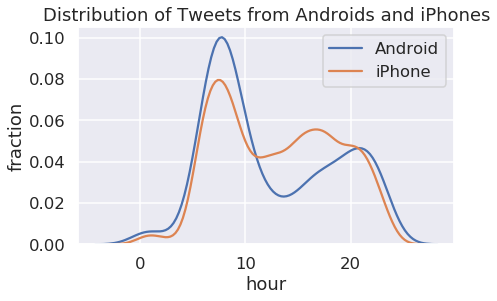

In [30]:
android = trump[trump['source'] == 'Twitter for Android']
iphone = trump[trump['source'] == 'Twitter for iPhone']
sns.distplot(android['hour'], hist = False, label = 'Android')
sns.distplot(iphone['hour'], hist = False, label = 'iPhone')
plt.ylabel('fraction')
plt.title('Distribution of Tweets from Androids and iPhones')


## Question 4d

According to [this Verge article](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android), Donald Trump switched from an Android to an iPhone sometime in March 2017.

Create a figure identical to your figure from 4c, except that you should show the results only from 2016. If you get stuck consider looking at the `year_fraction` function from the next problem.

During the campaign, it was theorized that Donald Trump's tweets from Android were written by him personally, and the tweets from iPhone were from his staff. Does your figure give support to this theory?

Text(0.5,1,'Distribution of Tweets from Androids and iPhones from 2016')

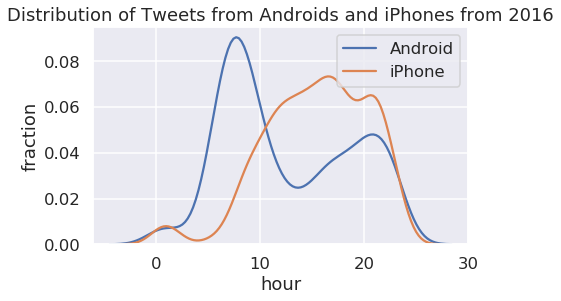

In [31]:
trump['year_only'] = [each.year for each in trump['est_time']]
tweets_2016 = trump[trump['year_only'] == 2016]
a_2016 = tweets_2016[tweets_2016['source'] == 'Twitter for Android']
i_2016 = tweets_2016[tweets_2016['source'] == 'Twitter for iPhone']

sns.distplot(a_2016['hour'], hist = False, label = 'Android')
sns.distplot(i_2016['hour'], hist = False, label = 'iPhone')
plt.ylabel('fraction')
plt.title('Distribution of Tweets from Androids and iPhones from 2016')

Looking at the 2 figures, we can see that for all tweets, Androids and iPhones send out around the same proportion of tweets at similar hours for tweets from all years. For tweets in 2016, tweets sent from Androids follow a similar distribution as the above figure, but tweets from iPhones send the majority of tweets between 10 AM - 8 PM. We know that Trump had an Android in 2016, but the distribution for Android tweets stays relatively similar with tweets in all years, so we cannot say that tweets sent from Androids were by Trump personally. 

## Question 5

Let's now look at which device he has used over the entire time period of this dataset.

To examine the distribution of dates we will convert the date to a fractional year that can be plotted as a distribution.

(Code borrowed from https://stackoverflow.com/questions/6451655/python-how-to-convert-datetime-dates-to-decimal-years)

In [32]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length


trump['year'] = trump['time'].apply(year_fraction)

In [59]:
trump.head()

,time,source,text,retweet_count,est_time,hour,year_only,year,no_punc,polarity,length
id,,,,,,,,,,,
1052233253040640001,2018-10-16 16:22:11,Twitter for iPhone,register to https://t.co/0pwiwchgbh! #maga🇺🇸 https://t.co/actme53tzu,5415,2018-10-16 11:22:11-05:00,11.369722,2018,2018.789041,register to https t co 0pwiwchgbh maga https t co actme53tzu,0.0,68
1052232230972678145,2018-10-16 16:18:08,Twitter for iPhone,rt @whitehouse: https://t.co/rnqlpots3o,4478,2018-10-16 11:18:08-05:00,11.302222,2018,2018.789041,rt whitehouse https t co rnqlpots3o,0.0,39
1052219253384994816,2018-10-16 15:26:33,Twitter for iPhone,"is it really possible that bruce ohr, whose wife nellie was paid by simpson and gps fusion for work done on the fake dossier, and who was used as a pawn in this whole scam (witch hunt), is still working for the department of justice????? can this really be so?????",13103,2018-10-16 10:26:33-05:00,10.442500,2018,2018.789041,is it really possible that bruce ohr whose wife nellie was paid by simpson and gps fusion for work done on the fake dossier and who was used as a pawn in this whole scam witch hunt is still working for the department of justice can this really be so,-3.9,264
1052217314463100928,2018-10-16 15:18:51,Twitter for iPhone,“conflict between glen simpson’s testimony to another house panel about his contact with justice department official bruce ohr. ohr was used by simpson and steele as a back channel to get (fake) dossier to fbi. simpson pleading fifth.” catherine herridge. where is jeff sessions?,6271,2018-10-16 10:18:51-05:00,10.314167,2018,2018.789041,conflict between glen simpson s testimony to another house panel about his contact with justice department official bruce ohr ohr was used by simpson and steele as a back channel to get fake dossier to fbi simpson pleading fifth catherine herridge where is jeff sessions,-1.0,279
1052213711295930368,2018-10-16 15:04:32,Twitter for iPhone,"“federal judge throws out stormy danials lawsuit versus trump. trump is entitled to full legal fees.” @foxnews great, now i can go after horseface and her 3rd rate lawyer in the great state of texas. she will confirm the letter she signed! she knows nothing about me, a total ...",14594,2018-10-16 10:04:32-05:00,10.075556,2018,2018.789041,federal judge throws out stormy danials lawsuit versus trump trump is entitled to full legal fees foxnews great now i can go after horseface and her 3rd rate lawyer in the great state of texas she will confirm the letter she signed she knows nothing about me a total ...,6.9,280


### Question 5a

Use the `sns.distplot` to overlay the distributions of the 2 most frequently used web technologies over the years.  Your final plot should look like:

<img src="images/source_years.png" width="600px" />


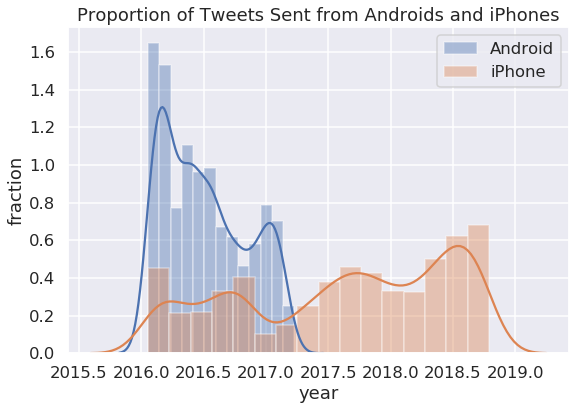

In [34]:
a_years = trump[trump['source'] == 'Twitter for Android']
i_years = trump[trump['source'] == 'Twitter for iPhone']

plt.figure(figsize= (8, 6))
sns.distplot(a_years['year'], label = 'Android')
sns.distplot(i_years['year'], label = 'iPhone')
plt.ylabel('fraction')
plt.title('Proportion of Tweets Sent from Androids and iPhones')
plt.legend()

## Question 6: Sentiment Analysis

It turns out that we can use the words in Trump's tweets to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [35]:
print(''.join(open("vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



## Question 6a

As you can see, the lexicon contains emojis too! The first column of the lexicon is the *token*, or the word itself. The second column is the *polarity* of the word, or how positive / negative it is.

(How did they decide the polarities of these words? What are the other two columns in the lexicon? See the link above.)

 Read in the lexicon into a DataFrame called `sent`. The index of the DF should be the tokens in the lexicon. `sent` should have one column: `polarity`: The polarity of each token.

In [36]:
sent = (
    pd.read_csv("vader_lexicon.txt", sep = '	', usecols = [0, 1], header = None)
    .rename(index = str, columns = {0: 'token', 1: 'polarity'})
    .set_index('token')
)


In [37]:
assert isinstance(sent, pd.DataFrame)
assert sent.shape == (7517, 1)
assert list(sent.index[5000:5005]) == ['paranoids', 'pardon', 'pardoned', 'pardoning', 'pardons']
assert np.allclose(sent['polarity'].head(), [-1.5, -0.4, -1.5, -0.4, -0.7])

## Question 6b

Now, let's use this lexicon to calculate the overall sentiment for each of Trump's tweets. Here's the basic idea:

1. For each tweet, find the sentiment of each word.
2. Calculate the sentiment of each tweet by taking the sum of the sentiments of its words.

First, let's lowercase the text in the tweets since the lexicon is also lowercase. Set the `text` column of the `trump` DF to be the lowercased text of each tweet.

In [38]:
trump['text'] = [tweet.lower() for tweet in trump['text']]
senti = []
value = 0
for tweet in trump['text']:
    for word in tweet:
        if word in sent.index:
            value += sent.loc[word,:][0]
        else:
            value = value
    senti += [value]
    


In [39]:
assert trump['text'].loc[884740553040175104] == 'working hard to get the olympics for the united states (l.a.). stay tuned!'

## Question 6c

Now, let's get rid of punctuation since it'll cause us to fail to match words. Create a new column called `no_punc` in the `trump` DF to be the lowercased text of each tweet with all punctuation replaced by a single space. We consider punctuation characters to be any character that isn't a Unicode word character or a whitespace character. You may want to consult the Python documentation on regexes for this problem.

(Why don't we simply remove punctuation instead of replacing with a space? See if you can figure this out by looking at the tweet data.)

In [40]:
# Save your regex in punct_re
punct_re = r'[^\w\s]'
trump['no_punc'] = trump['text'].str.replace(punct_re, ' ')

In [41]:
assert isinstance(punct_re, str)
assert re.search(punct_re, 'this') is None
assert re.search(punct_re, 'this is ok') is None
assert re.search(punct_re, 'this is\nok') is None
assert re.search(punct_re, 'this is not ok.') is not None
assert re.search(punct_re, 'this#is#ok') is not None
assert re.search(punct_re, 'this^is ok') is not None
assert trump['no_punc'].loc[800329364986626048] == 'i watched parts of  nbcsnl saturday night live last night  it is a totally one sided  biased show   nothing funny at all  equal time for us '
assert trump['no_punc'].loc[894620077634592769] == 'on  purpleheartday i thank all the brave men and women who have sacrificed in battle for this great nation   usa   https   t co qmfdlslp6p'
# If you fail these tests, you accidentally changed the text column
assert trump['text'].loc[884740553040175104] == 'working hard to get the olympics for the united states (l.a.). stay tuned!'

## Question 6d:


Now, let's convert the tweets into what's called a [*tidy format*](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) to make the sentiments easier to calculate. Use the `no_punc` column of `trump` to create a table called `tidy_format`. The index of the table should be the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

The first few rows of our `tidy_format` table look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>num</th>
      <th>word</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>894661651760377856</th>
      <td>0</td>
      <td>i</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>1</td>
      <td>think</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>2</td>
      <td>senator</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>3</td>
      <td>blumenthal</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>4</td>
      <td>should</td>
    </tr>
  </tbody>
</table>

**Note that you'll get different results depending on when you pulled in the tweets.** However, you can double check that your tweet with ID `894661651760377856` has the same rows as ours. Our tests don't check whether your table looks exactly like ours.

As usual, try to avoid using any for loops. Our solution uses a chain of 5 methods on the 'trump' DF, albeit using some rather advanced Pandas hacking.

* **Hint 1:** Try looking at the `expand` argument to pandas' `str.split`.

* **Hint 2:** Try looking at the `stack()` method.

* **Hint 3:** Try looking at the `level` parameter of the `reset_index` method.


In [42]:
tidy_format = (
    trump['no_punc'].str.split(expand = True)
    .stack()
    .reset_index()
    .rename(index = str, columns = {'level_1': 'num', 0: 'word'})
    .set_index('id')
)
tidy_format.index.name = None


In [43]:
assert tidy_format.loc[894661651760377856].shape == (27, 2)
assert ' '.join(list(tidy_format.loc[894661651760377856]['word'])) == 'i think senator blumenthal should take a nice long vacation in vietnam where he lied about his service so he can at least say he was there'

## Question 6e:

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each tweet: we can join the table with the lexicon table. 

Add a `polarity` column to the `trump` table.  The `polarity` column should contain the sum of the sentiment polarity of each word in the text of the tweet.

**Hint** you will need to merge the `tidy_format` and `sent` tables and group the final answer.


In [44]:
grouped = tidy_format.merge(sent, how = 'left',right_index = True, left_on = 'word').fillna(0).sort_index()
trump['polarity'] = grouped.groupby(grouped.index)['polarity'].sum().reset_index().set_index('index')

In [45]:
assert np.allclose(trump.loc[744701872456536064, 'polarity'], 8.4)
assert np.allclose(trump.loc[745304731346702336, 'polarity'], 2.5)
assert np.allclose(trump.loc[744519497764184064, 'polarity'], 1.7)
assert np.allclose(trump.loc[894661651760377856, 'polarity'], 0.2)
assert np.allclose(trump.loc[894620077634592769, 'polarity'], 5.4)
# If you fail this test, you dropped tweets with 0 polarity
assert np.allclose(trump.loc[744355251365511169, 'polarity'], 0.0)

Now we have a measure of the sentiment of each of his tweets! Note that this calculation is rather basic; you can read over the VADER readme to understand a more robust sentiment analysis.

Now, run the cells below to see the most positive and most negative tweets from Trump in your dataset:

In [46]:
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   it is outrageous that poisonous synthetic heroin fentanyl comes pouring into the u.s. postal system from china. we can, and must, end this now! the senate should pass the stop act – and firmly stop this poison from killing our children and destroying our country. no more delay!

   the rigged russian witch hunt goes on and on as the “originators and founders” of this scam continue to be fired and demoted for their corrupt and illegal activity. all credibility is gone from this terrible hoax, and much more will be lost as it proceeds. no collusion!

   james comey is a proven leaker &amp; liar. virtually everyone in washington thought he should be fired for the terrible job he did-until he was, in fact, fired. he leaked classified information, for which he should be prosecuted. he lied to congress under oath. he is a weak and.....

   this is an illegally brought rigged witch hunt run by people who are totally corrupt and/or conflicted. it was started and paid 

In [47]:
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   congratulations to patrick reed on his great and courageous masters win! when patrick had his amazing win at doral 5 years ago, people saw his great talent, and a bright future ahead. now he is the masters champion!

   my supporters are the smartest, strongest, most hard working and most loyal that we have seen in our countries history. it is a beautiful thing to watch as we win elections and gather support from all over the country. as we get stronger, so does our country. best numbers ever!

   thank you to all of my great supporters, really big progress being made. other countries wanting to fix crazy trade deals. economy is roaring. supreme court pick getting great reviews. new poll says trump, at over 90%, is the most popular republican in history of the party. wow!

   thank you, @wvgovernor jim justice, for that warm introduction. tonight, it was my great honor to attend the “greenbrier classic – salute to service dinner” in west virginia! god bless ou

## Question 6g

Plot the distribution of tweet sentiments broken down by whether the text of the tweet contains `nyt` or `fox`.  Then in the box below comment on what we observe?

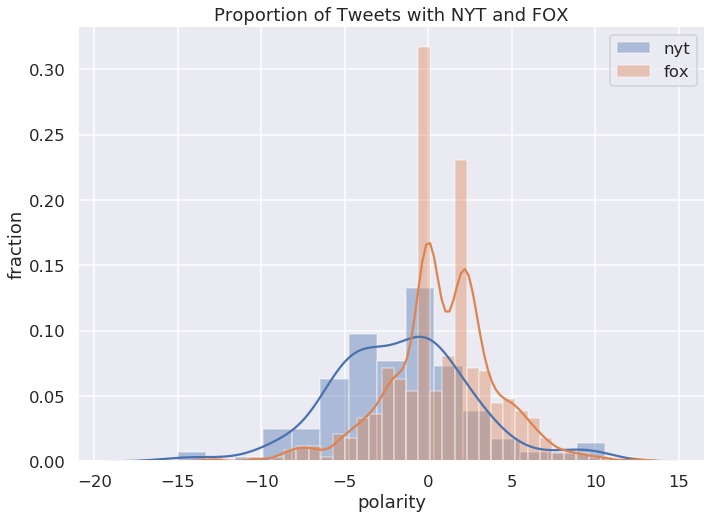

In [48]:
nyt = trump[trump['text'].str.contains('nyt')]
fox = trump[trump['text'].str.contains('fox')]

plt.figure(figsize = (10,8))
sns.distplot(nyt['polarity'], label = 'nyt')
sns.distplot(fox['polarity'], label = 'fox')
plt.ylabel('fraction')
plt.title('Proportion of Tweets with NYT and FOX')
plt.legend()


#### Comment on what you observe:

From the figure,I can see that the sentiment of tweets containing 'fox' seem to be more positive than tweets containing 'nyt.' The proportion of tweets with 'fox' with a sentiment of 0 and around 3 is also very high, meaning those tweets are neutral to positive. Tweets with 'nyt' are highest with a sentiment of -5 and -1 - 0, so the tweets range from negative to neutral. 

In [58]:
tidy_format.head()

,num,word
1052233253040640001,0,register
1052233253040640001,1,to
1052233253040640001,2,https
1052233253040640001,3,t
1052233253040640001,4,co


## Question 7: Engagement

## Question 7a

In this problem, we'll explore which words led to a greater average number of retweets. For example, at the time of this writing, Donald Trump has two tweets that contain the word 'oakland' (tweets 932570628451954688 and 1016609920031117312) with 36757 and 10286 retweets respectively, for an average of 23,521.5.

Find the top 20 most retweeted words. Include only words that appear in at least 25 tweets. As usual, try to do this without any for loops. You can string together ~7 pandas commands and get everything done on one line.

Your `top_20` table should have this format:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>retweet_count</th>
    </tr>
    <tr>
      <th>word</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>jong</th>
      <td>40675.666667</td>
    </tr>
    <tr>
      <th>try</th>
      <td>33937.800000</td>
    </tr>
    <tr>
      <th>kim</th>
      <td>32849.595745</td>
    </tr>
    <tr>
      <th>un</th>
      <td>32741.731707</td>
    </tr>
    <tr>
      <th>maybe</th>
      <td>30473.192308</td>
    </tr>
  </tbody>
</table>

In [50]:
counts = (
    tidy_format['word'].value_counts()
    .to_frame()
    .reset_index()
    .rename(index = str, columns = {'index': 'word', 'word': 'count'})
)
ret = trump[['retweet_count']]
with_counts = (
    tidy_format.merge(counts, how = 'right', right_index = True, on = 'word')
    .merge(ret, left_index = True, right_index = True)
    .drop(columns = 'num')
)

In [51]:
top_20 = (
    with_counts.loc[with_counts['count'] > 24, :]
    .groupby('word').mean().sort_values(['retweet_count'], ascending = False)
    .head(20)
    .drop(columns = 'count')
)
top_20

,retweet_count
word,
jong,40592.833333
try,33907.000000
un,32677.024390
kim,32237.306122
maybe,30413.153846
nuclear,29146.560000
kavanaugh,28651.962963
old,28280.333333
illegally,28130.870968


In [52]:
# Although it can't be guaranteed, it's very likely that the top 5 words will still be
# in the top 20 words in the next month.
assert 'jong'     in top_20.index
assert 'try'     in top_20.index
assert 'kim' in top_20.index
assert 'un'    in top_20.index
assert 'maybe'    in top_20.index


Here's a bar chart of your results:

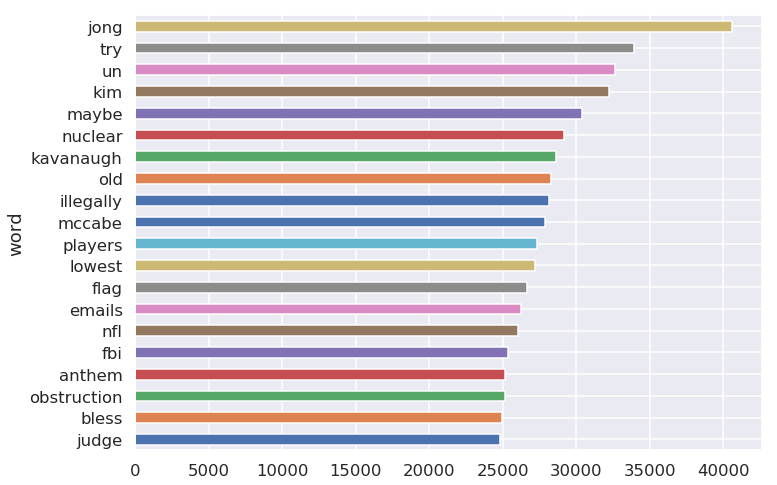

In [53]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8));

## Question 7b

"kim", "jong" and "un" are apparently really popular in Trump's tweets! It seems like we can conclude that his tweets involving jong are more popular than his other tweets. Or can we?

Consider each of the statements about possible confounding factors below. State whether each statement is true or false and explain. If the statement is true, state whether the confounding factor could have made kim jong un related tweets higher in the list than they should be.

1. We didn't restrict our word list to nouns, so we have unhelpful words like "let" and "any" in our result.
1. We didn't remove hashtags in our text, so we have duplicate words (eg. #great and great).
1. We didn't account for the fact that Trump's follower count has increased over time.

1. False, words such as 'let' or 'any' do not really affect how popular tweets with 'kim', 'jong', 'un' are. Since we are taking the average, we get rid of filler words, which is evident in the fact that none of the top 20 words are filler words.
2. True, it is possible that there are duplicate words in the hashtags, which could be a factor if Trump did use 'kim', 'jong', or 'un' in a hashtag.
3. True, we did not account for when the tweets were posted and whether the ones we are comparing are from the same time period. This means that tweets that are more recent are more likely to have more retweets as his followers has increased over time. Kim Jong Un only became the leader of North Korea in 2012, so Trump would have been less likely to mention him in tweets earlier than 2012, when he had fewer followers. 

## Question 8

Using the `trump` tweets construct an interesting plot describing a property of the data and discuss what you found below.

**Ideas:**

1. How has the sentiment changed with length of the tweets?
1. Does sentiment affect retweet count?
1. Are retweets more negative than regular tweets?
1. Are there any spikes in the number of retweets and do the correspond to world events? 
1. *Bonus:* How many Russian twitter bots follow Trump? 
1. What terms have an especially positive or negative sentiment?

You can look at other data sources and even tweets.


### Plot:

In [54]:
trump['length'] = [len(tweet) for tweet in trump['no_punc']]

In [55]:
trump_2018 = trump[trump['year_only'] == 2018]
trump_2018['hour'] = [int(hour) for hour in trump_2018['hour']]
time = ['0-5a','0-5a','0-5a','0-5a','0-5a','0-5a','6-11a','6-11a','6-11a','6-11a','6-11a','6-11a','12-5p','12-5p','12-5p','12-5p','12-5p','12-5p','6-11p','6-11p','6-11p','6-11p','6-11p','6-11p']
time_num = range(24)
time_dict = dict(zip(time_num, time))
time_dict

trump_2018['hour'].replace(time_dict, inplace = True)

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


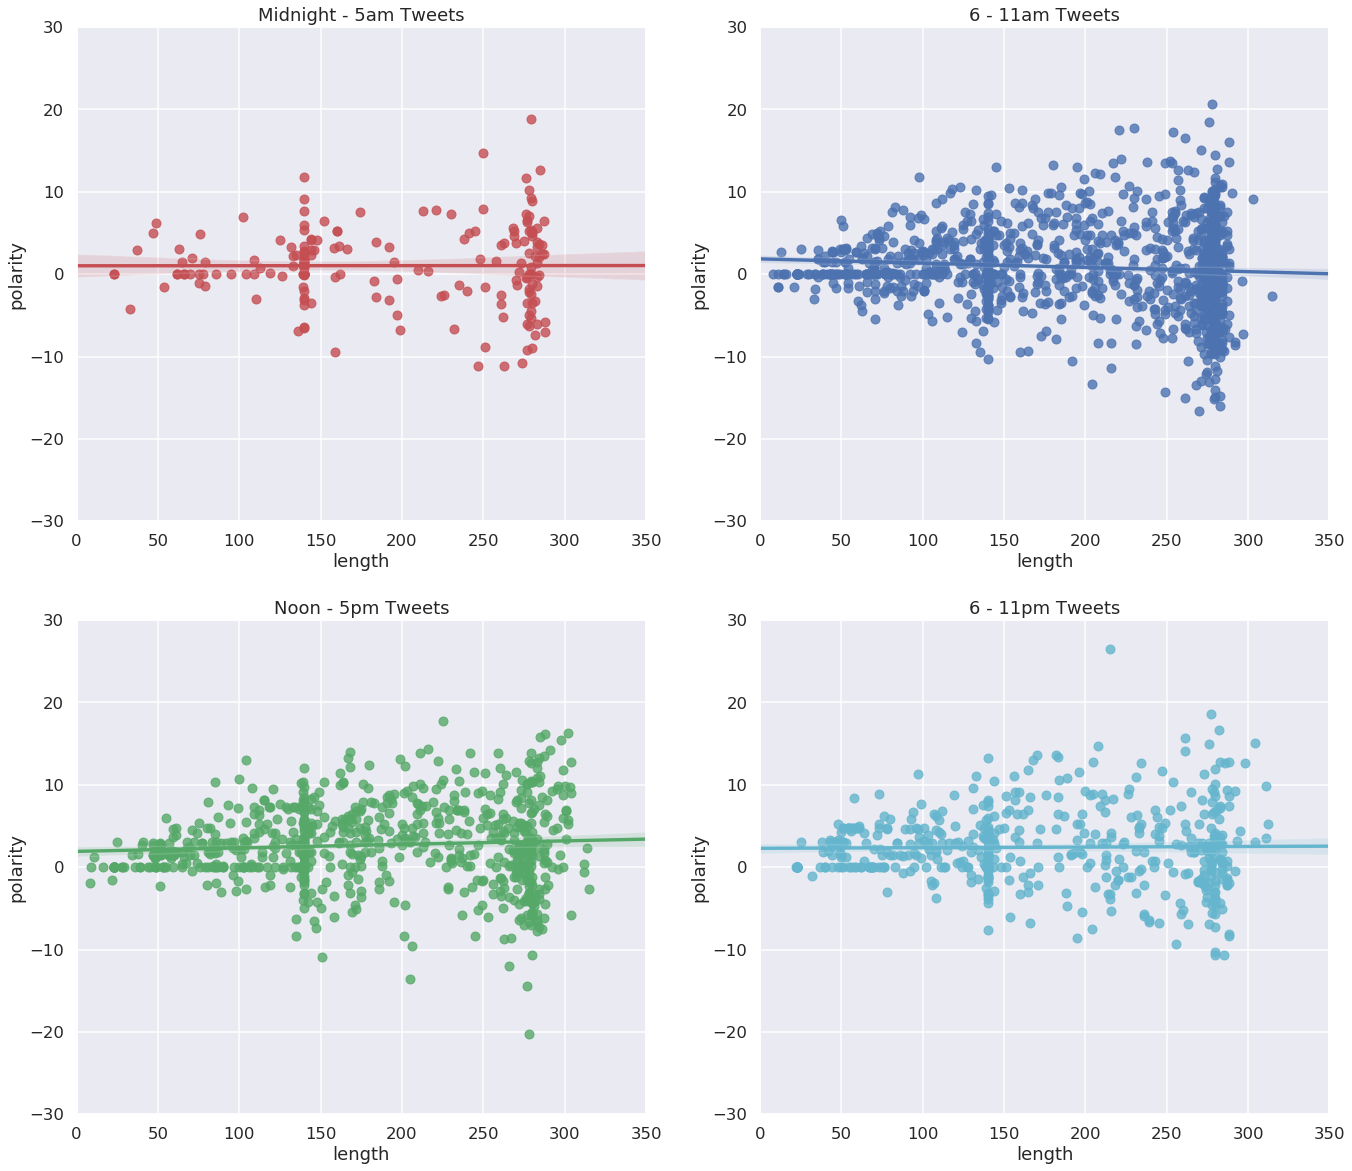

In [56]:
plt.figure(figsize=(20, 20))
one = trump_2018[trump_2018['hour'] == '0-5a']
two = trump_2018[trump_2018['hour'] == '6-11a']
three = trump_2018[trump_2018['hour'] == '12-5p']
four = trump_2018[trump_2018['hour'] == '6-11p']

#0-5am = 191 tweets
a = plt.subplot(2, 2, 1)
a.set_title('Midnight - 5am Tweets')
plt.axis([0, 350, -30, 30])
sns.regplot(x = 'length', y = 'polarity', data = one, color = 'r')
#6-11am = 1189 tweets
b = plt.subplot(2, 2, 2)
b.set_title('6 - 11am Tweets')
plt.axis([0, 350, -30, 30])
sns.regplot(x = 'length', y = 'polarity', data = two, color = 'b')
#12-5pm = 747 tweets
c = plt.subplot(2, 2, 3)
c.set_title('Noon - 5pm Tweets')
plt.axis([0, 350, -30, 30])
sns.regplot(x = 'length', y = 'polarity', data = three, color = 'g')
#6-11pm = 524 tweets 
d = plt.subplot(2, 2, 4)
d.set_title('6 - 11pm Tweets')
plt.axis([0, 350, -30, 30])
sns.regplot(x = 'length', y = 'polarity', data = four, color = 'c')

Text(0.5,1,'Distribution of Tweet Sentiments Separated by Hour Posted')

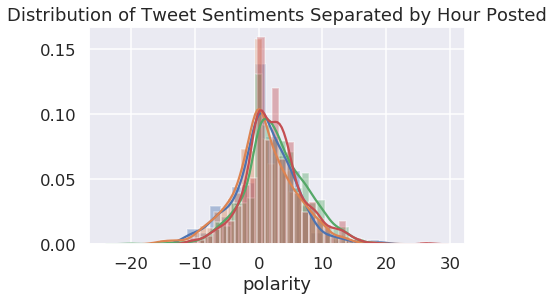

In [57]:
sns.distplot(one['polarity'])
sns.distplot(two['polarity'])
sns.distplot(three['polarity'])
sns.distplot(four['polarity'])
plt.title('Distribution of Tweet Sentiments Separated by Hour Posted')

### Discussion of Your Plot:

I looked at all of Trump's tweets from 2018, and separated them by the time of day that they were posted. I separated them out by hours because there were so many tweets and it was very difficult to see any kind of pattern in the data. I then plotted the length of the tweets against the polarity and also compared the distribution of the polarity for all tweets in 2018. 

Through these figures, I can see that the fewest tweets are posted between midnight and 5 am (191) and most tweets are posted between 6 to 11 am (1186). All four plots have a similar distribution of tweet sentiments. This is further proven by the overlaid distriubtion plots of the polarity, separated by the hour of the day, where you can see that the tweets follow a similar distribution centered around 0. As the tweets get longer, it is harder to predict how positive or negative the tweets are, as the sentiments stray form 0.

The regression lines are all 4 plots are above 0, so the tweets are slightly more positive. Something else interesting is tweets from 6-11am seem to get more negative as the tweet get longer, but tweets from 12-5pm get more positive. The regression line does not show a very obvious difference, but could be worth exploring, whether tweets during a certain time are more controversial or PC. 

## Submission

Congrats, you just finished Project 1!

## Submission

You're done!

Before submitting this assignment, ensure to:

1. Restart the Kernel (in the menubar, select Kernel->Restart & Run All)
2. Validate the notebook by clicking the "Validate" button

Finally, make sure to **submit** the assignment via the Assignments tab in Datahub